# Machine learning Project 1 : Higgs Boson

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import sys
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import *

data_path = "datasets/train.csv"
yb, input_data, ids = load_csv_data(data_path, sub_sample=False)

### Clean data 
We set to 0 the invalid values and standardize the data by columns.

In [3]:
cleansubx = input_data
cleansubx[np.where(cleansubx == -999)] = 0
means_by_columns = np.mean(cleansubx, axis=0)

for i in range(30):
    input_data[:,np.where(input_data[:,i]==-999)] = means_by_columns[i]
    
input_data = standardize(input_data)
rows, cols = input_data.shape[0], input_data.shape[1]

Histograms of the features to see their distribution.

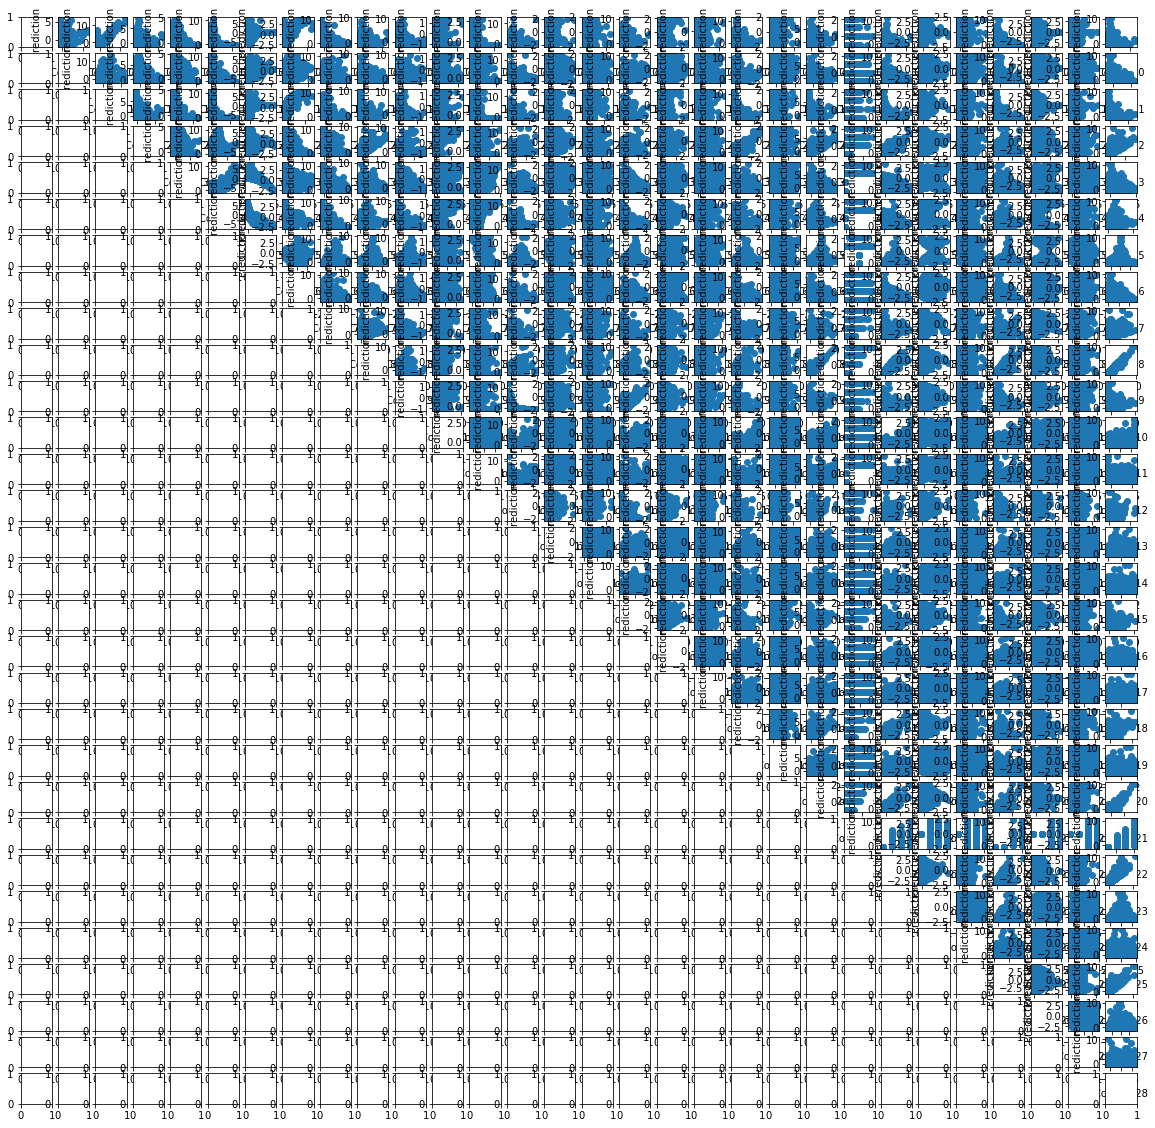

In [4]:
# Plot of the y variables against each of the features

fig0, axs = plt.subplots(30,30, figsize=(20,20))

for i in range(30):
    for j in range(i+1,30):
        axs[i,j].scatter(input_data[:,i], input_data[:,j])
        axs[i,j].set_ylabel('Prediction')
        axs[i,j].set_xlabel('Column %i' % i)
    

Correlation coefficients of the features, to understand if they are linearly correlated

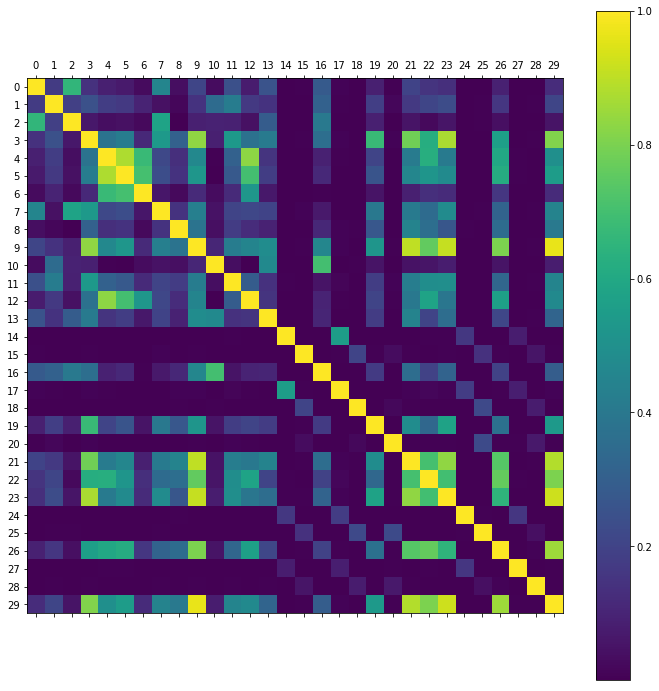

In [12]:
cor_matrix = np.corrcoef(input_data.T)

plt.figure(1, figsize=(12,12))
plt.matshow(np.abs(cor_matrix),1)
plt.xticks(range(cols), range(cols))
plt.yticks(range(cols), range(cols))
plt.colorbar()
plt.savefig('correlation_matrix'+'.png')

We decide to leave out columns 5, 9, 12, 21, 22, 23, 29 due to the high correlation with the others.

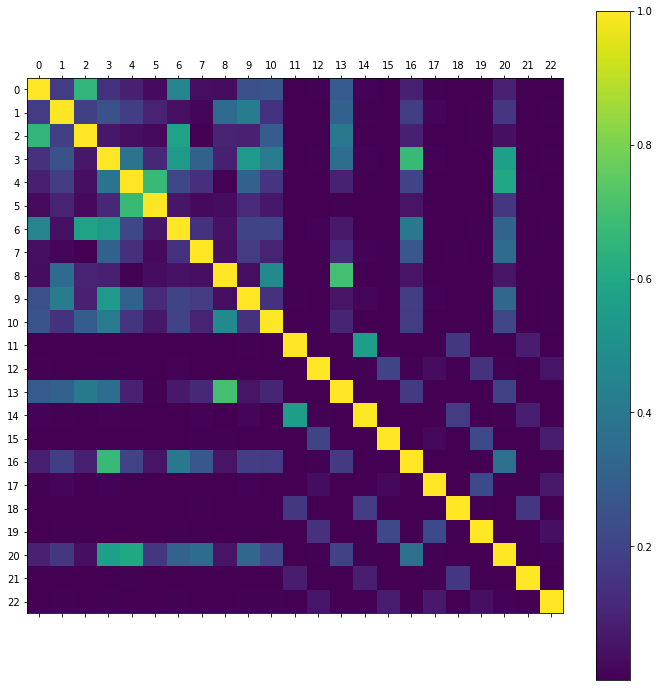

In [13]:
data = np.delete(input_data,[5,9,12,21,22,23,29],1)

#Compute again the correlation and check
cor_matrix = np.corrcoef(data.T)
plt.figure(2, figsize=(12,12))
plt.matshow(np.abs(cor_matrix),2)
plt.xticks(range(23), range(23))
plt.yticks(range(23), range(23))
plt.colorbar()
plt.savefig('correlation_new'+'.png')



# Fitting a linear model
First of all we fit our linear model on the subset of data, and then use the whole train dataset to test it, at least at the beginning. In the end we will use the whole dataset to train the model. We try with 5 polynomial degrees per feature, otherwise the number of features becomes too large.
Compare the mse and the computational time of the 3 methods to get the least squares solution: the first one is the correct one, but maybe the others are faster.


1.Linear regression with mse and normal equations


2.Linear regression with mse and gradient descent


3.Linear regression with mse and stochastic gradient descent



In [6]:
# Function that builds a polynomial basis of the chosen degree for a column 
def build_poly_col(x, degree):
    """polynomial basis functions for input column x, for j=1 up to j=degree."""
    
    y = x
        
    for n in range(2,degree+1):
        x = np.c_[x, np.power(y,n)]
            
    return x

# Function that builds a polynomial basis for the data (each column has the same degree)
def build_poly(data, degree):
    """polynomial basis for input data up to the chosen degree in each column"""
    
    X = np.c_[np.ones(data.shape[0])]
    for j in range(data.shape[1]):
        x_col = build_poly_col(data[:,j], degree)
        X = np.c_[X, x_col]
        
    return X


In [7]:
# Functions to build the indices and split the data to perform cross validation

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)


def split_dataset(y, x, k, k_indices):
    """Returns the matrices and vectors Test and Train used in a k-fold cross validation"""
    
    # get k'th subgroup in test, others in train.
    X_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    X_train = np.delete(x,k_indices[k],0)
    y_train = np.delete(y,k_indices[k])
    
    return X_test, y_test, X_train, y_train


In [8]:

from implementations import *

def ls_polynomial_basis(yb, data, kfolds, degree):
    """Builds a polynomial basis according to the chosen degree and solves the least squares problem
        with the normal equations, performing a k-fold cross validation to compute the rmse and the weights"""
    
    rmse_train=[]
    rmse_test=[]
    seed = 2

    # Build indices to split data
    k_indices = build_k_indices(yb, kfolds, seed)

    # Define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    std_tr = []
    std_te = []

    # Choose the degrees and loop over them

    for degree in degrees:
        rmse_tr_k=[]
        rmse_te_k=[]
    
        # Build X matrix
        data1 = build_poly(data, degree)
    
        # Loop over the folds
        for k in range(kfolds):
        
            data_test_ls, y_test_ls, data_train_ls, y_train_ls = split_dataset(yb, data1, k, k_indices)   
        
            # Train and store rmse
            w_ls_k, mse_ls_k = least_squares(y_train_ls, data_train_ls)
            rmse_test = np.sqrt(2*compute_mse(y_test_ls, data_test_ls, w_ls_k))
            
            
            rmse_tr_k.append(np.sqrt(2*mse_ls_k))
            rmse_te_k.append(rmse_test)
        
        # Append rmse (and std over the folds) in the vectors
        rmse_tr.append(np.mean(rmse_tr_k))
        rmse_te.append(np.mean(rmse_te_k))
        std_tr.append(np.std(rmse_tr_k))
        std_te.append(np.std(rmse_te_k))

    return rmse_tr, rmse_te, std_tr, std_te, w_ls_k

We try this first simple model both on the matrix with all the features and on the reduced matrix, and compare the results.

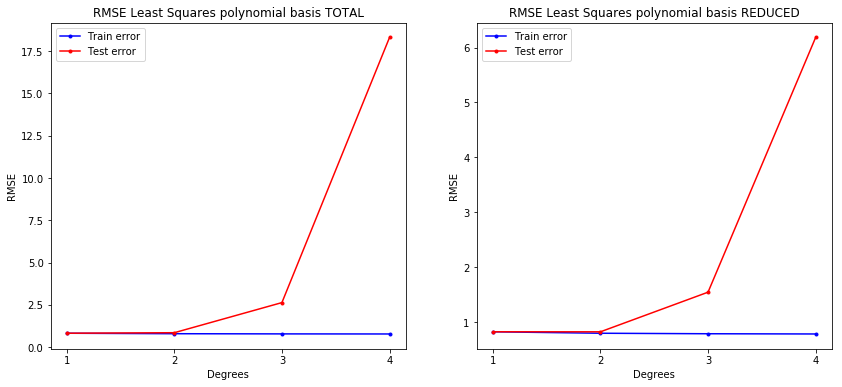

In [11]:
degrees = range(1,5)

rmse_train_tot, rmse_test_tot, std_train_tot, std_test_tot, w= ls_polynomial_basis(yb, input_data, 5, degrees)
rmse_train_red, rmse_test_red, std_train_red, std_test_red, w_to_use = ls_polynomial_basis(yb, data, 5, degrees)


# Plot RMSE to compare the results
fig3, axs= plt.subplots(1,2, figsize=(14,6))
axs[0].plot(degrees, rmse_train_tot, marker=".", c='b', label='Train error')
axs[0].plot(degrees, rmse_test_tot, marker=".", c='r', label='Test error')
#plt.errorbar(degrees, rmse_tr, std_tr, marker=".", color='b', label='Train error')
#plt.errorbar(degrees, rmse_te, std_te, marker=".", color='r', label='Test error')
axs[0].set_xlabel("Degrees")
axs[0].set_ylabel("RMSE")
axs[0].set_title("RMSE Least Squares polynomial basis TOTAL")
axs[0].legend(loc=2)
axs[0].set_xticks(degrees)

axs[1].plot(degrees, rmse_train_red, marker=".", c='b', label='Train error')
axs[1].plot(degrees, rmse_test_red, marker=".", c='r', label='Test error')
axs[1].set_xlabel("Degrees")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE Least Squares polynomial basis REDUCED")
axs[1].legend(loc=2)
axs[1].set_xticks(degrees)
plt.savefig("rmse_ls")


In both cases we find a significant overfitting even at a low degree (3,4) and to try to reduce it we use ridge regression. Before doing that, we try to minimize the mse loss function with GD and SGD: we should get an approximation of the minimum, but maybe save computational time. However we should put a lot of effort in tuning the parameters for the iterative method (max_iter, gamma) and maybe it's not worth it.